In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import optuna
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [2]:
# Image display func
def show_image(img):
    plt.imshow(img, cmap='binary')

In [3]:
# Define data transformations (e.g., normalization, augmentation)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Loading MNIST
train_dataset = datasets.MNIST(root='../data/', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='../data/', train=False, download=False, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

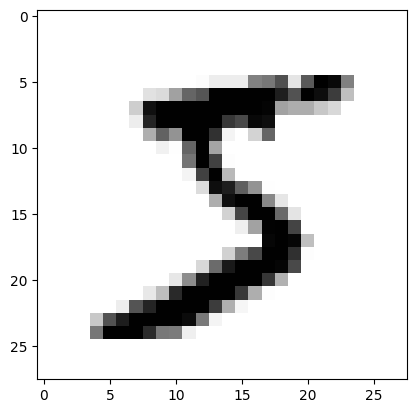

In [4]:
show_image(train_dataset[0][0][0])

In [5]:
torch.manual_seed(0)

# Using modified LeNet-5 architecture

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1,
                            out_channels=6,
                            kernel_size=5,
                            stride=1), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,
                               stride=2),
            nn.Conv2d(in_channels=6,
                            out_channels=16,
                            kernel_size=5,
                            stride=1), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2,
                               stride=2,
                               padding=1),
            nn.Conv2d(in_channels=16,
                            out_channels=120,
                            kernel_size=5,
                            stride=1), nn.ReLU(),
        )
        self.linear_block = nn.Sequential(
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.linear_block(x)
        return x

In [6]:
model = LeNet().to(device)
print(model)

LeNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (linear_block): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)


In [7]:
# Loss function and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
num_epochs = 500
loss_values = []

In [8]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Feed-forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    
    # Append the loss for this epoch to the list
    loss_values.append(avg_loss)
    
    # Optionally, print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/500, Loss: 2.3026
Epoch 2/500, Loss: 2.3024
Epoch 3/500, Loss: 2.3022
Epoch 4/500, Loss: 2.3020
Epoch 5/500, Loss: 2.3017
Epoch 6/500, Loss: 2.3012
Epoch 7/500, Loss: 2.2999
Epoch 8/500, Loss: 2.2883
Epoch 9/500, Loss: 1.9114
Epoch 10/500, Loss: 1.8151
Epoch 11/500, Loss: 1.8044
Epoch 12/500, Loss: 1.7666
Epoch 13/500, Loss: 1.7143
Epoch 14/500, Loss: 1.7069
Epoch 15/500, Loss: 1.7020
Epoch 16/500, Loss: 1.6985
Epoch 17/500, Loss: 1.6946
Epoch 18/500, Loss: 1.6918
Epoch 19/500, Loss: 1.6893
Epoch 20/500, Loss: 1.6864
Epoch 21/500, Loss: 1.6227
Epoch 22/500, Loss: 1.6053
Epoch 23/500, Loss: 1.5995
Epoch 24/500, Loss: 1.5958
Epoch 25/500, Loss: 1.5585
Epoch 26/500, Loss: 1.5220
Epoch 27/500, Loss: 1.5138
Epoch 28/500, Loss: 1.5080
Epoch 29/500, Loss: 1.5039
Epoch 30/500, Loss: 1.5004
Epoch 31/500, Loss: 1.4980
Epoch 32/500, Loss: 1.4957
Epoch 33/500, Loss: 1.4939
Epoch 34/500, Loss: 1.4923
Epoch 35/500, Loss: 1.4913
Epoch 36/500, Loss: 1.4898
Epoch 37/500, Loss: 1.4885
Epoch 38/5

KeyboardInterrupt: 

In [10]:
# Interrupted training early since it stopped improving

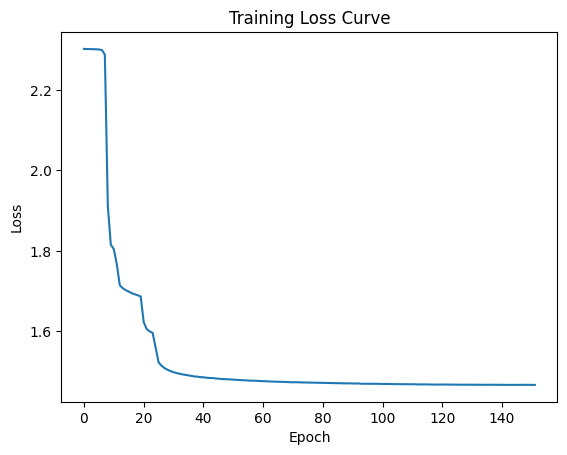

In [9]:
# Evaluation
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

In [26]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        # Counting total samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculating accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the test dataset: {accuracy:.2f}%')

Accuracy of the network on the test dataset: 98.47%


In [27]:
#checking weights
#for name, module in model.named_modules():
#    if isinstance(module, torch.nn.Conv2d):
#        print(f"Layer: {name}")
#        print(module.weight)

In [33]:
with open('../model/modified_LeNet.pkl', 'wb') as file:
    pickle.dump(model, file)